In [1]:
import numpy as np
from keras.src.saving.saving_api import load_model
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from sklearn.metrics import accuracy_score
from PIL import Image
import tensorflow as tf
from skimage import feature
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import logging
from ast import literal_eval
from joblib import load
import csv

import matplotlib.pyplot as plt

# Gán nhãn cho từng dự đoán

In [2]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
           9:'No passing',   
           10:'No passing veh over 3.5 tons',     
           11:'Right-of-way at intersection',     
           12:'Priority road',    
           13:'Yield',     
           14:'Stop',       
           15:'No vehicles',       
           16:'Veh > 3.5 tons prohibited',       
           17:'No entry',       
           18:'General caution',     
           19:'Dangerous curve left',      
           20:'Dangerous curve right',   
           21:'Double curve',      
           22:'Bumpy road',     
           23:'Slippery road',       
           24:'Road narrows on the right',  
           25:'Road work',    
           26:'Traffic signals',      
           27:'Pedestrians',     
           28:'Children crossing',     
           29:'Bicycles crossing',       
           30:'Beware of ice/snow',
           31:'Wild animals crossing',      
           32:'End speed + passing limits',      
           33:'Turn right ahead',     
           34:'Turn left ahead',       
           35:'Ahead only',      
           36:'Go straight or right',      
           37:'Go straight or left',      
           38:'Keep right',     
           39:'Keep left',      
           40:'Roundabout mandatory',     
           41:'End of no passing',      
           42:'End no passing veh > 3.5 tons' }

# Tính toán đặc trưng ảnh

In [3]:
def compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((128, 128))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

### Thử với một ảnh

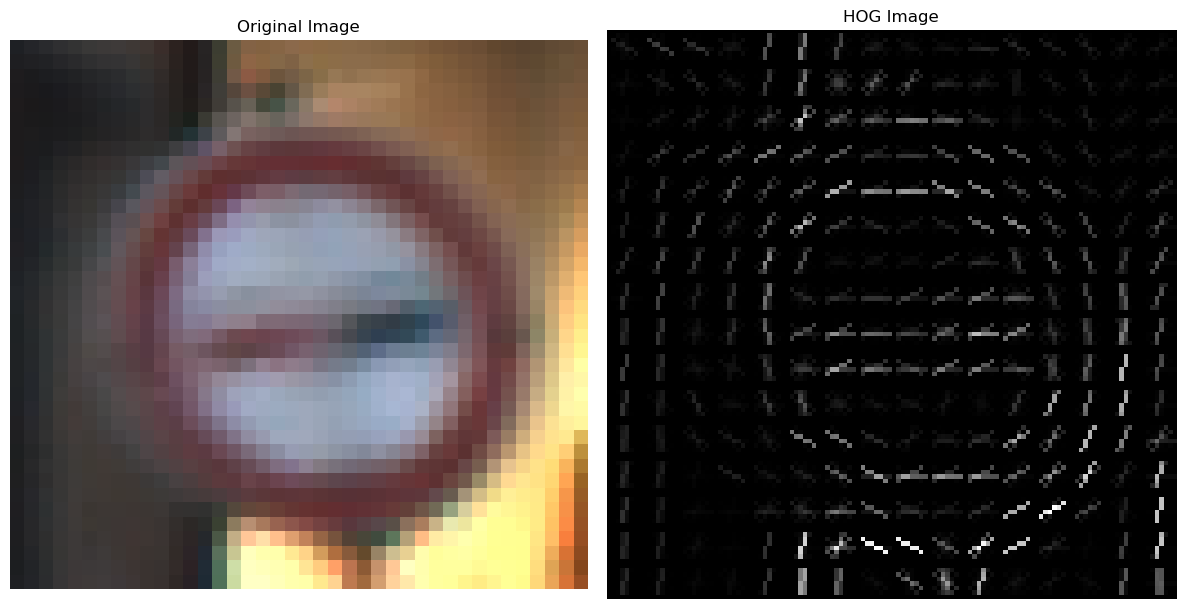

Kích thước của HOG features cho ảnh: (8100,)


In [4]:
def test_compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((128, 128))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog, _
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

# Đường dẫn tới thư mục chứa ảnh
image_folder = './data/test/'

# Tên file ảnh cần thử nghiệm
image_filename = "12578.png"

# Khởi tạo danh sách lưu trữ HOG features và hình ảnh
features = []
hog_images = []
original_images = []

# Tính toán HOG features và HOG images cho ảnh
image_path = os.path.join(image_folder, image_filename)
hog_feature, hog_image = test_compute_hog(image_path)
features.append(hog_feature)
hog_images.append(hog_image)
original_images.append(Image.open(image_path))

# Hiển thị hình ảnh gốc và HOG image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_images[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_images[0], cmap=plt.cm.gray)
plt.title('HOG Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# In ra kích thước của HOG features cho ảnh
print(f"Kích thước của HOG features cho ảnh: {np.array(features[0]).shape}")


### Tải dữ liệu và trích xuất đặc trưng

In [5]:
def load_data_from_csv(csv_file):
    data = []
    labels = []

    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        for line in lines:
            parts = line.strip().split(',')
            image_path = parts[-1]
            hog = compute_hog("./data/" + image_path)
            if hog is not None:
                data.append(hog)
                labels.append(int(parts[-2]))  # ClassId là phần thứ 2 từ cuối dòng
    return np.array(data), np.array(labels)

In [6]:
X_train, Y_train = load_data_from_csv("./data/Train.csv")

In [7]:
X_train

array([[0.23774285, 0.        , 0.03385776, ..., 0.08669832, 0.2857048 ,
        0.2857048 ],
       [0.        , 0.        , 0.        , ..., 0.31038459, 0.18627728,
        0.12943961],
       [0.32507678, 0.        , 0.04466683, ..., 0.23369199, 0.        ,
        0.        ],
       ...,
       [0.26788997, 0.        , 0.09320252, ..., 0.16436833, 0.        ,
        0.        ],
       [0.29785438, 0.13475587, 0.14077172, ..., 0.26428568, 0.26428568,
        0.06014992],
       [0.24760278, 0.09476172, 0.119992  , ..., 0.07105677, 0.        ,
        0.        ]])

In [47]:
X_test, Y_test = load_data_from_csv("./data/test.csv")

###  Thống kê dữ liệu

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\3443763203.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


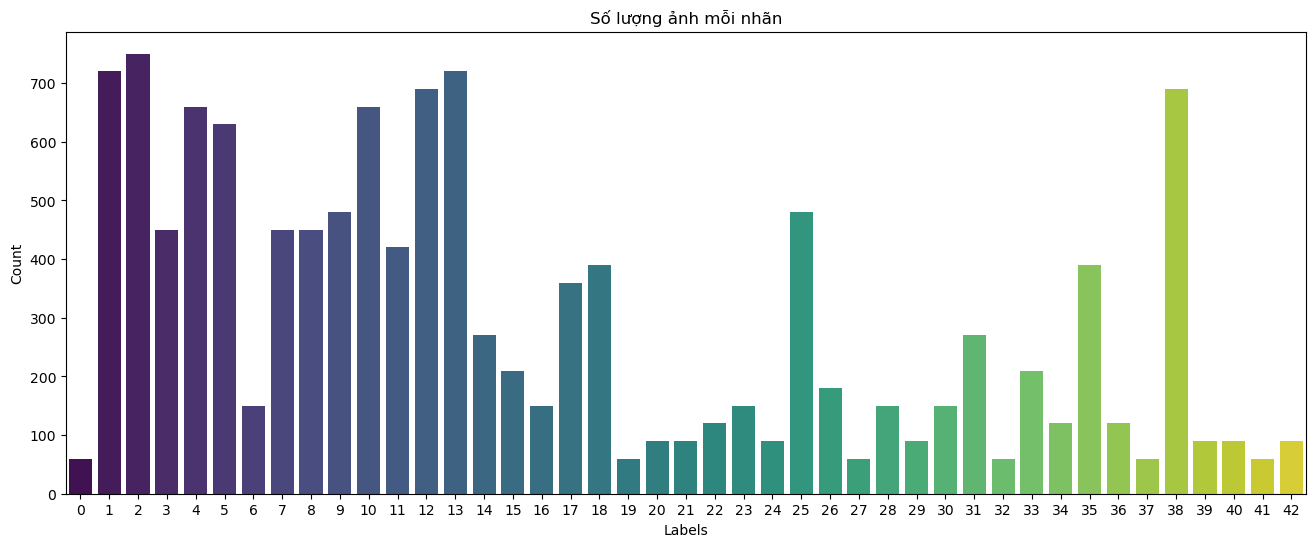

In [51]:
import seaborn as sns
unique, counts = np.unique(Y_test, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Số lượng ảnh mỗi nhãn')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\3633194060.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


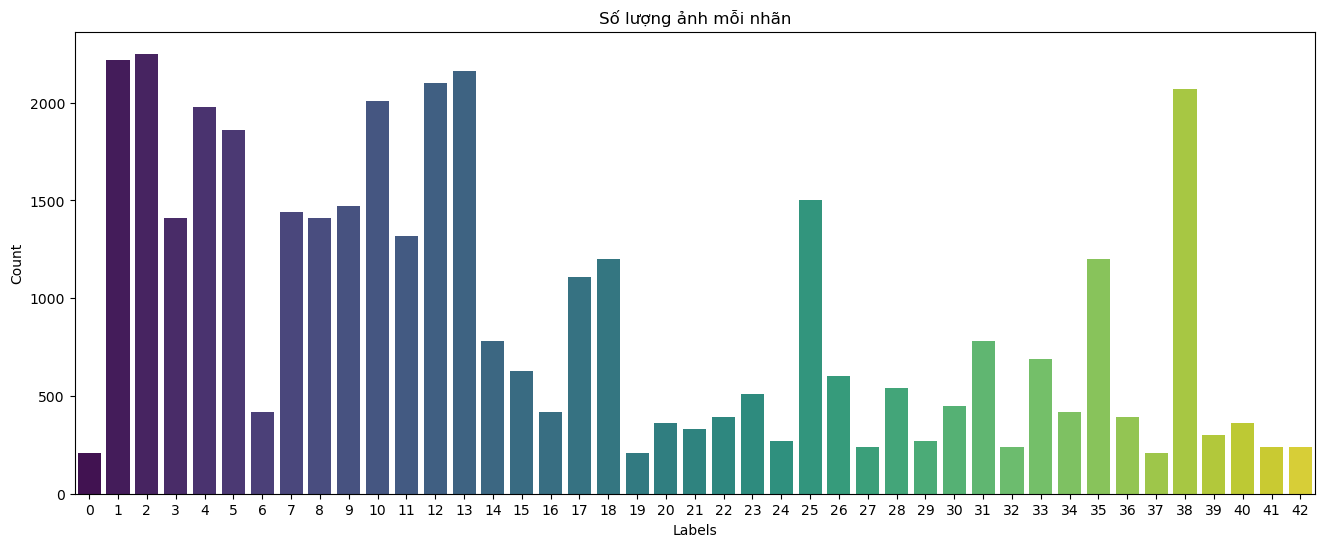

In [8]:
import seaborn as sns
unique, counts = np.unique(Y_train, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Số lượng ảnh mỗi nhãn')
plt.show()

In [9]:
import numpy as np

# Giả sử y_train_resampled là mảng chứa các nhãn sau khi thực hiện over-sampling
unique, counts = np.unique(Y_train, return_counts=True)
label_counts = dict(zip(unique, counts))

print(label_counts)

{0: 210, 1: 2220, 2: 2250, 3: 1410, 4: 1980, 5: 1860, 6: 420, 7: 1440, 8: 1410, 9: 1470, 10: 2010, 11: 1320, 12: 2100, 13: 2160, 14: 780, 15: 630, 16: 420, 17: 1110, 18: 1200, 19: 210, 20: 360, 21: 330, 22: 390, 23: 510, 24: 270, 25: 1500, 26: 600, 27: 240, 28: 540, 29: 270, 30: 450, 31: 780, 32: 240, 33: 689, 34: 420, 35: 1200, 36: 390, 37: 210, 38: 2070, 39: 300, 40: 360, 41: 240, 42: 240}


### Xử lý dữ liệu không cân bằng

In [10]:
sampling_strategy = {
0: 1000, 1: 2220, 2: 2250, 
3: 1410, 4: 1980, 5: 1860,
6: 1000, 7: 1440, 8: 1410, 
9: 1470, 10: 2010, 11: 1320, 
12: 2100, 13: 2160, 14: 1000, 
15: 1000, 16: 1000, 17: 1110, 
18: 1200, 19: 1000, 20: 1000,
21: 1000, 22: 1000, 23: 1000,
24: 1000, 25: 1500, 26: 1000, 
27: 1000, 28: 1000, 29: 1000, 
30: 1000, 31: 1000, 32: 1000, 
33: 1000, 34: 1000, 35: 1200, 
36: 1000, 37: 1000, 38: 2070, 
39: 1000, 40: 1000, 41: 1000, 
42: 1000
}

In [40]:
from imblearn.over_sampling import SMOTE

# Giả sử X_train và y_train là dữ liệu và nhãn
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\313957556.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


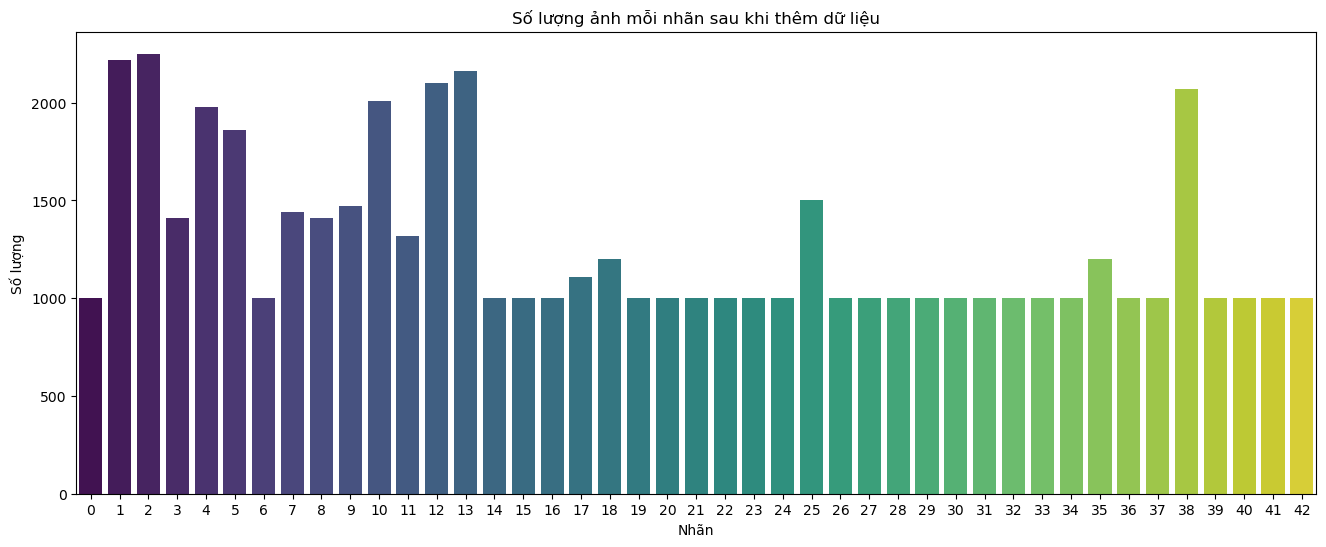

In [41]:
import seaborn as sns
unique, counts = np.unique(y_train_resampled, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Số lượng ảnh mỗi nhãn sau khi thêm dữ liệu')
plt.show()